# Stochastic Volatility model

In [1]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(\frac{y_i}{y_{i-1}}) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [2]:
n = 400
returns = np.genfromtxt(pm.get_data("SP500.csv"))[-n:]
returns[:5]

array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])

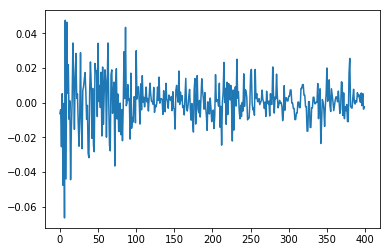

In [3]:
plt.plot(returns)

Specifying the model in pymc3 mirrors its statistical specification. 

In [4]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    nu = pm.Exponential('nu', 1./10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm.StudentT('r', nu, lam=pm.math.exp(-2*s), observed=returns)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. To get good convergence with NUTS we use ADVI (autodiff variational inference) for initialization.

In [8]:
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,130.4:  34%|███▍      | 67873/200000 [00:15<00:31, 4184.66it/s]
Convergence archived at 68100
Interrupted at 68,100 [34%]: Average Loss = 505.57
100%|██████████| 2000/2000 [01:44<00:00, 20.78it/s]


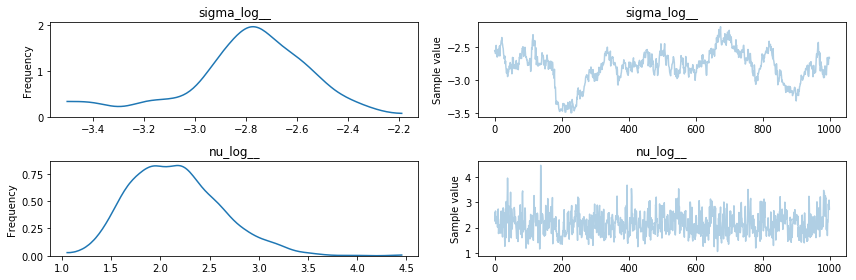

In [9]:
figsize(12,6)
pm.traceplot(trace, model.vars[:-1]);

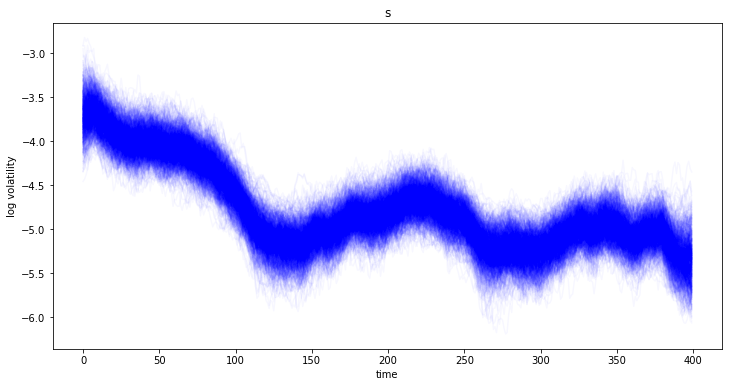

In [10]:
figsize(12,6)
title(str(s))
plot(trace[s].T, 'b', alpha=.03);
xlabel('time')
ylabel('log volatility')

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

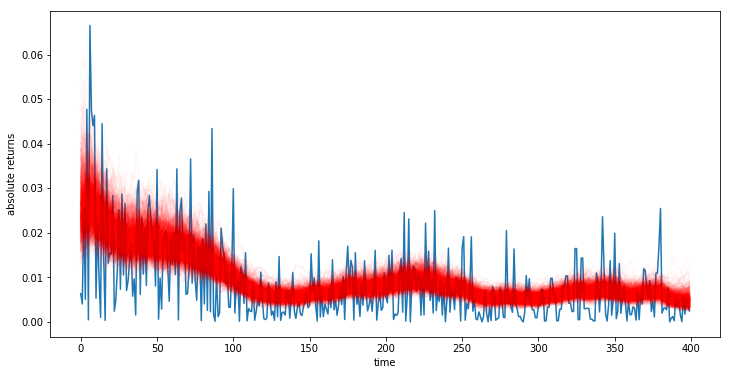

In [11]:
plot(np.abs(returns))
plot(np.exp(trace[s].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
xlabel('time')
ylabel('absolute returns')

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 